<img src="../images/UBC_MDS_logo.PNG" width="130" height="130" align="right"/>

# Lecture 4 - Linear Mixed-Effects Models
### DSCI 562 - Regression II

Alexi Rodríguez-Arelis, **January 2021**

<h1>Outline<br><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Learning-Goals" data-toc-modified-id="1.-Learning-Goals-1">1. Learning Goals </a></span></li><li><span><a href="#2.-Linear-Fixed-Effects-Model" data-toc-modified-id="2.-Linear-Fixed-Effects-Model-2">2. Linear Fixed-Effects Model </a></span></li><li><span><a href="#3.-Linear-Mixed-Effects-Model" data-toc-modified-id="3.-Linear-Mixed-Effects-Model-3">3. Linear Mixed-Effects Model </a></span></li></ul></div>

In [2]:
suppressPackageStartupMessages(library(AER))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(nlme))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(lmerTest))

## 1. Learning Goals

By the end of this lecture, we will be able to:

- Identify the model assumptions in a linear mixed-effects model.
- Associate a term (or combination of terms) in a mixed-effects model with the following quantities:

    - Fixed effect estimates.
    - Variances of the random effects.
    - Regression coefficients for each group and the population.
    - Predictions on existing groups and a new group.

- Fit a linear mixed-effects model in `R`, and extract estimates of the above quantities.
- Identify the consequences of fitting a fixed-effects linear regression model when there are groups, whether a slope parameter is pooled or fit separately per group.
- Explain the difference between the distributional assumption on the random effects and the fixed effects estimates' sampling distribution.

## 2. Linear Fixed Effects Model

So far, we have been working with regression models fitted with a sample of $n$ *independent elements*. Given a set of $p$ regressors $X_{i,j}$ and a continuous response $Y_i$, we fit a model

\begin{equation*}
Y_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_p X_{i,p} + \varepsilon_{i} \; \; \; \; \text{for} \; i = 1, \ldots, n.
\end{equation*}

The coefficients $\beta_0, \dots, \beta_p$ are fixed and constant for **all the observed values** $\left(x_{i,1}, \dots, x_{i,p}, y_i\right)$.

These coefficients are called **fixed effects**. It is of our interest to evaluate whether they are statistically significant or not on the response.

### 2.1. Grunfeld's Investment Dataset

Consider the following example: to study how gross investment depends on the firm's value and capital stock, [Grunfeld (1958)](https://ezproxy.library.ubc.ca/login?url=https://search.proquest.com/docview/301899386?pq-origsite=summon) collected data from eleven different companies over the years 1935-1954.

> The data frame `Grunfeld` contains 220 observations from a balanced panel of 11 firms from 1935 to 1954 (20 observations per `firm`). The dataset includes a continuous response `investment` subject to two explanatory variables, `market_value` and `capital`.

Firstly, we will load the data which has the following variables:

- `investment`: the gross investment in millions of dollars (additions to plant and equipment along with maintenance), a continuous response.
- `market_value`: the firm's market value in millions of dollars, a continuous explanatory variable.
- `capital`: stock of plant and equipment in millions of dollars, a continuous explanatory variable.
- `firm`: a nominal explanatory variable with eleven levels indicating the firm (`General Motors`, `US Steel`, `General Electric`, `Chrysler`, `Atlantic Refining`, `IBM`, `Union Oil`, `Westinghouse`, `Goodyear`, `Diamond Match`, and `American Steel`).
- `year`: the year of the observation (it will not be used in our analysis).

In [3]:
data(Grunfeld)
Grunfeld <- Grunfeld %>% rename(investment = invest, market_value = value)
head(Grunfeld)
tail(Grunfeld)

,investment,market_value,capital,firm,year
,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,317.6,3078.5,2.8,General Motors,1935
2,391.8,4661.7,52.6,General Motors,1936
3,410.6,5387.1,156.9,General Motors,1937
4,257.7,2792.2,209.2,General Motors,1938
5,330.8,4313.2,203.4,General Motors,1939
6,461.2,4643.9,207.2,General Motors,1940


,investment,market_value,capital,firm,year
,<dbl>,<dbl>,<dbl>,<fct>,<int>
215,6.433,39.961,73.827,American Steel,1949
216,4.770,36.494,75.847,American Steel,1950
217,6.532,46.082,77.367,American Steel,1951
218,7.329,57.616,78.631,American Steel,1952
219,9.020,57.441,80.215,American Steel,1953
220,6.281,47.165,83.788,American Steel,1954


### In-Class Activity
 
What class of data hierarchy do you observe in this dataset?

> 1. Two levels of detail in the data:

        - Grunfeld first sampled the eleven firms (level 1). 
        - Then, for each firm, Grunfeld collected 20 data points (level 2).

> 2. We would expect data within a company to be correlated.

### Main Modelling Objective

We are interested in assessing the relationship of gross `investment` with `market_value` and `capital` **while taking `firm` into account**. How can we fit a linear model to this data?

> Based on what we have seen, we can think of four approaches:

- Take the average for each `firm`, and fit a linear model on the averages (not an ideal approach).
- We could ignore `firm`, and fit an ordinary linear model with the dataset (not an ideal approach).
- Allow different intercept for each `firm`.
- Allow a different slope and intercept for each `firm` (interaction model).

Let us plot the 220 data points of `investment` versus `market_value` but facetted by `firm` and use `geom_smooth()` to fit sub-models by `firm`.

In [4]:
scatterplots_firm <- Grunfeld %>%
  ggplot(aes(market_value, investment)) +
  geom_point() +
  geom_smooth(method = "lm", fullrange = TRUE, se = FALSE) +
  facet_wrap(~firm) +
  labs(x = "Market Value (Millions of Dollars)", y = "Gross Investment (Millions of Dollars)") +
  ggtitle("Scatterplots by Firm") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    strip.text.x = element_text(size = 16),
  )

`geom_smooth()` using formula 'y ~ x'



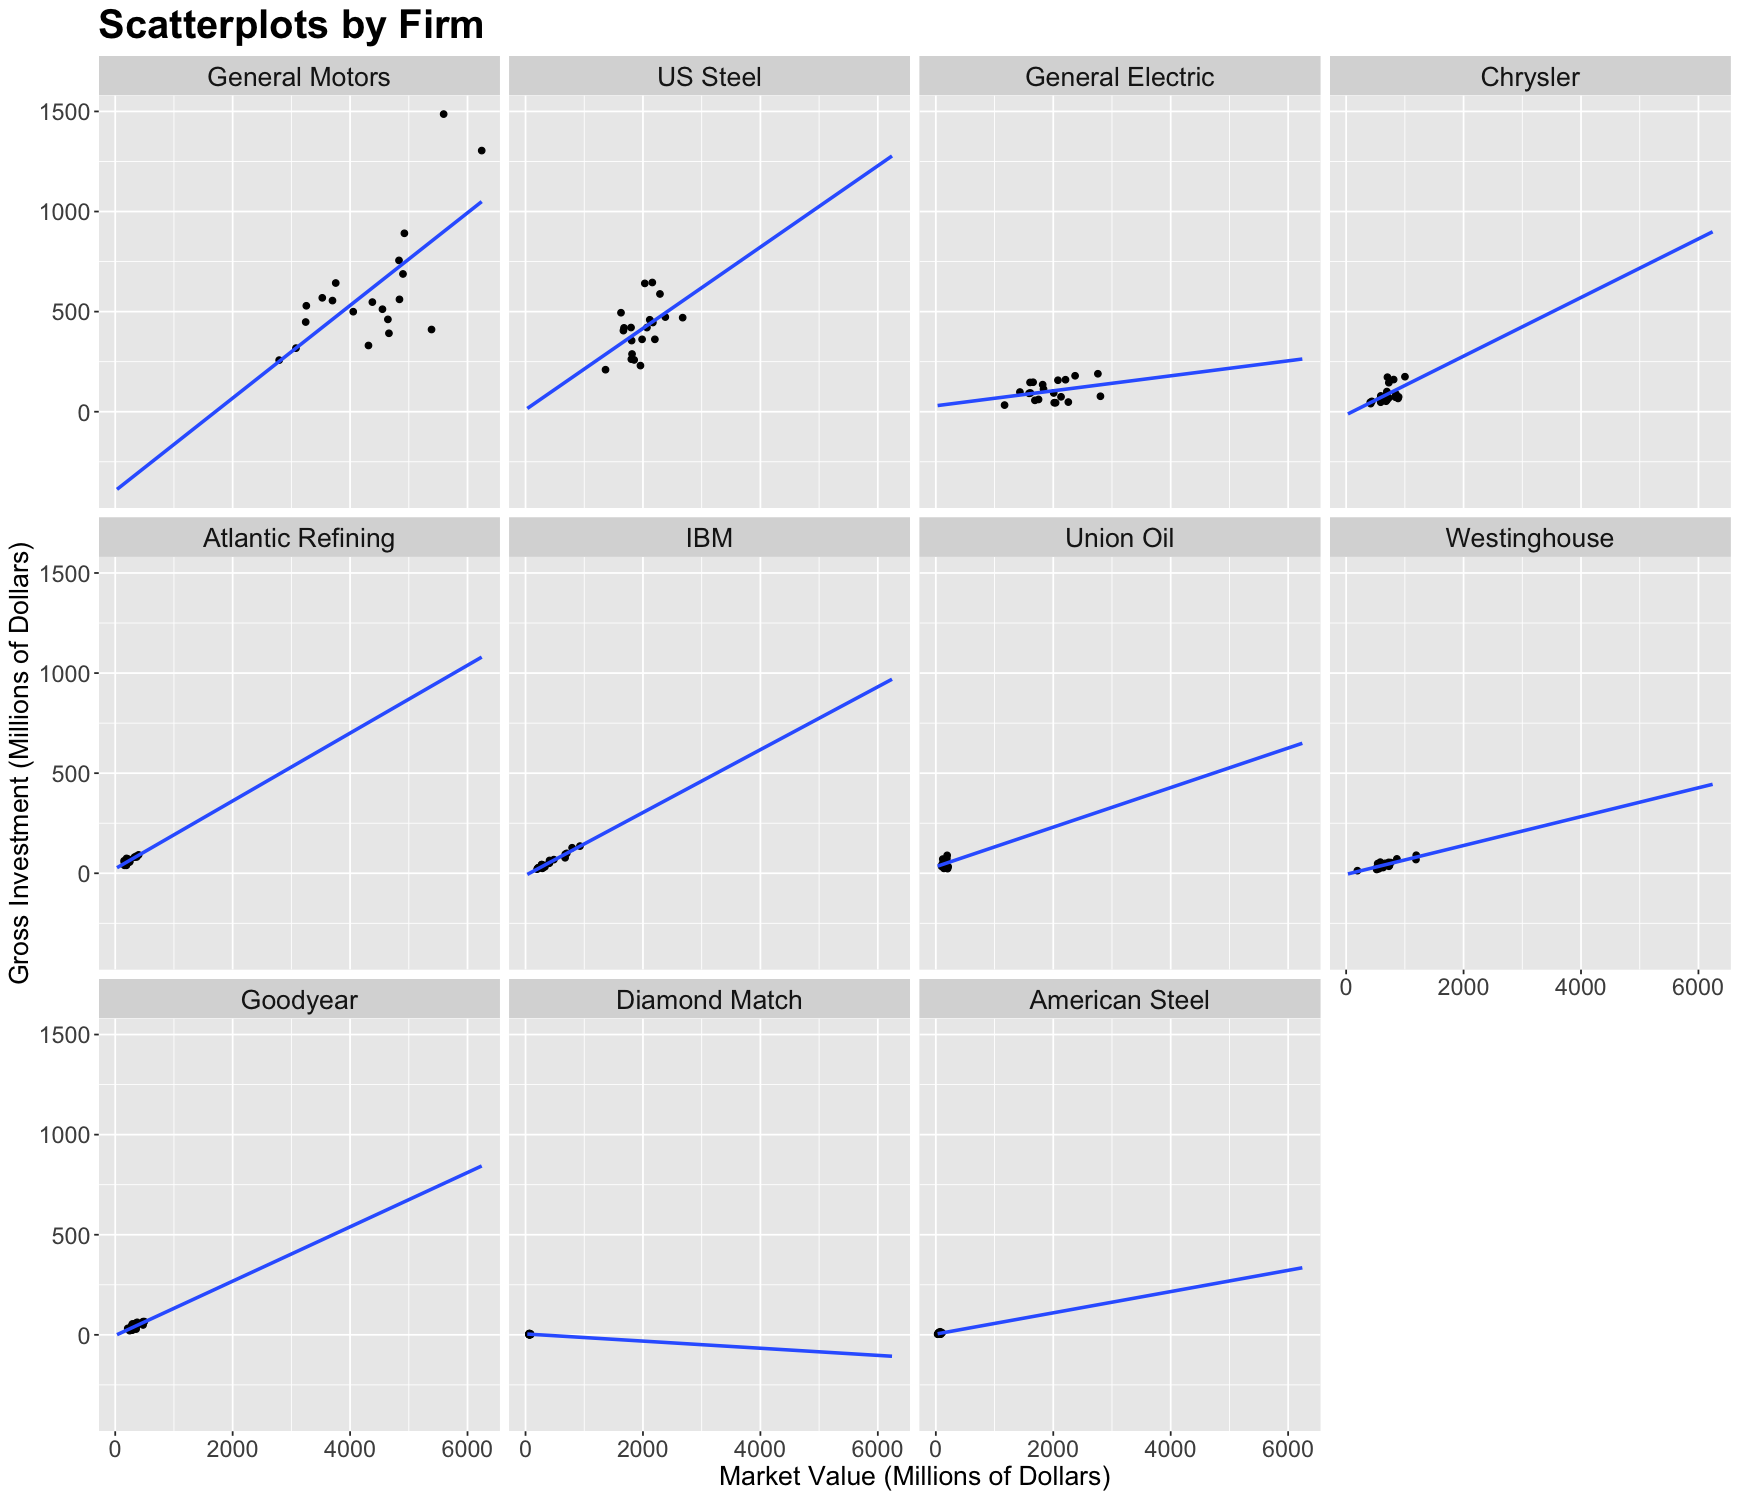

In [7]:
options(repr.plot.height = 12.5, repr.plot.width = 14.5)
scatterplots_firm

### In-Class Activity

What do you observe in the plots above?

> The intercept seems to be 0 for all the firms, except the first one.

> The effect of the `firm` is clear in the way the data is distributed. For example, `General Motors` certainly has a higher variance than `American Steel`.

> There seems to be some variability in the slopes for different firms.

### Ordinary Linear Regression Model

Suppose we ignore the factor `firm`. Let us estimate a classical linear regression model with `investment` as a response to `market_value` and `capital` as regressors.

The regression equation for the $i$th sampled observation will be:

\begin{equation*}
\texttt{investment}_{i} = \beta_0 + \beta_1 \texttt{marketValue}_{i} + \beta_2\texttt{capital}_{i} + \varepsilon_{i} \; \; \; \; \text{for} \; i = 1, \ldots, 220.
\end{equation*}

In [8]:
ordinary_model <- lm(investment ~ market_value + capital, data = Grunfeld)
tidy(ordinary_model) %>%
  mutate_if(is.numeric, round, 2)
glance(ordinary_model) %>%
  mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-38.41,8.41,-4.57,0
market_value,0.11,0.01,20.75,0
capital,0.23,0.02,9.39,0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.82,0.82,90.28,487.28,0,2,-1301.3,2610.6,2624.17,1768678,217,220


### Linear Regression Model with Varying Intercept

Now, let us estimate another linear regression model with `investment` as a response to `market_value` and `capital` as regressors **but with varying intercepts by each `firm`**.

We will do this with the `lm()` function by adding `- 1` on the right-hand side of the argument `formula`. This `- 1` will allow the baseline `firm` to have its intercept (i.e., renaming `(Intercept)` in column `estimate` with `firmCompanyName`).

In [9]:
levels(Grunfeld$firm)

[1] "General Motors"    "US Steel"          "General Electric" 
 [4] "Chrysler"          "Atlantic Refining" "IBM"              
 [7] "Union Oil"         "Westinghouse"      "Goodyear"         
[10] "Diamond Match"     "American Steel"

In [10]:
model_varying_intercept <- lm(investment ~ market_value + capital + firm - 1, data = Grunfeld)
tidy(model_varying_intercept) %>%
  mutate_if(is.numeric, round, 2)
glance(model_varying_intercept) %>%
  mutate_if(is.numeric, round, 2) 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_value,0.11,0.01,9.75,0.00
capital,0.31,0.02,18.74,0.00
firmGeneral Motors,-70.30,47.38,-1.48,0.14
firmUS Steel,101.90,23.77,4.29,0.00
firmGeneral Electric,-235.57,23.29,-10.12,0.00
firmChrysler,-27.81,13.42,-2.07,0.04
firmAtlantic Refining,-114.60,13.50,-8.49,0.00
firmIBM,-23.16,12.08,-1.92,0.06
firmUnion Oil,-66.54,12.24,-5.44,0.00


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.96,0.96,50.3,398.23,0,13,-1167.43,2362.85,2410.36,523718.7,207,220


By checking the `adj.r.squared`, we see that `model_varying_intercept` has a larger value (0.96) than `ordinary_model` (0.82).

We can test if there is a gain in considering a varying intercept versus fixed intercept. Hence, we will make a formal $F$-test to check whether the `model_varying_intercept` fits the data better than the `ordinary_model`.

In [11]:
anova(ordinary_model, model_varying_intercept) %>%
  mutate_if(is.numeric, round, 2) 

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,217,1768678.4,NA,NA,NA,NA
2,207,523718.7,10,1244960,49.21,0


We obtain a $p\text{-value} < .001$. Thus, with $\alpha = 0.05$, we have evidence to conclude that `model_varying_intercept` fits the data better than the `ordinary_model`.

However, this costs us one extra degree of freedom per `firm` *except for the baseline*. Therefore, we lose another 10 degrees of freedom.

> In this specific case, losing 10 degrees of freedom is not a big deal with 220 data points. Nonetheless, in other cases when data is scarce, this could be an issue.

### In-Class Activity

What is the sample's regression equation for `model_varying_intercept`?

The regression equation for the $i$th sampled observation in the $j$th `firm` will be:

\begin{equation*}
\texttt{investment}_{i,j} = \beta_{0,j} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \; \; \; \; \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{equation*}

> **Note that there is a varying term $\beta_{0,j}$ which is indexed with the $j$th `firm`.**

### A Linear Regression Model for Each Firm

We can make the model more complex with two interactions (`market_value * firm` and `capital * firm`). This will estimate a linear regression by `firm`.

In [12]:
model_by_firm <- lm(investment ~ market_value * firm + capital * firm, data = Grunfeld)
tidy(model_by_firm) %>%
  mutate_if(is.numeric, round, 2)
glance(model_by_firm) %>%
  mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-149.78,48.07,-3.12,0.00
market_value,0.12,0.01,10.17,0.00
firmUS Steel,100.58,80.04,1.26,0.21
firmGeneral Electric,139.83,67.16,2.08,0.04
firmChrysler,143.59,64.09,2.24,0.03
firmAtlantic Refining,172.49,57.52,3.00,0.00
firmIBM,141.10,53.48,2.64,0.01
firmUnion Oil,145.28,69.34,2.10,0.04
firmWestinghouse,149.27,58.14,2.57,0.01


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.97,0.96,41.68,168.84,0,32,-1114.91,2297.81,2413.2,324895.6,187,220


We are now estimating a linear regression for each `firm`. In this case, we are fitting eleven linear regressions, each with 20 points.

> We have plenty of data points in this case for all the degrees of freedom required to estimate each parameter. Nonetheless, this might not be the case with other datasets.

### In-Class Activity

What is the sample's regression equation for `model_by_firm`?

The regression equation for the $i$th sampled observation in the $j$th `firm` will be:

\begin{equation*}
\texttt{investment}_{i,j} = \beta_{0,j} + \beta_{1,j} \texttt{marketValue}_{i,j} + \beta_{2,j} \texttt{capital}_{i,j} + \varepsilon_{i,j} \; \; \; \; \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{equation*}

> **Note that the terms $\beta_{0,j}$, $\beta_{1,j}$, and $\beta_{2,j}$ (indexed with the $j$th) vary by `firm`.**

We went as far as fitting a separate linear regression for each `firm`. How to interpret the coefficients in this model?

> Each regression coefficient is associated with a `firm`. For example, $\texttt{firmUS Steel:capital} = 0.02$ means that the variable `capital` has a slope of $0.02 + 0.37 = 0.39$. for `US Steel`. We can double-check this by estimating an individual linear regression for `US Steel`:

In [13]:
tidy(lm(investment ~ market_value + capital, data = Grunfeld %>% filter(firm == "US Steel"))) %>%
  mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-49.20,148.08,-0.33,0.74
market_value,0.17,0.07,2.36,0.03
capital,0.39,0.14,2.74,0.01


Are we in line with the main modelling objective with all these linear regression models?

> Actually, not. Grunfeld wanted to see how capital and market value affect gross investment among the companies. Not for *one specific `firm`*! The conclusions must be valid for "all" the companies.

## 3. Linear Mixed Effects Model

Let us take a step back and think about a population of companies. For instance, all American companies.

Grunfeld did not collect data on all the American companies but sampled 11 companies from this population. He was interested in assessing whether `market_value` and `capital` were related to `investment` and by how much.

Let us assume that the $j$th sampled `firm` has its own intercept $b_{0,j}$ and the **overall fixed intercept** is $\beta_0$. Therefore, for the $j$th firm we define the following **mixed** intercept:

\begin{equation*}
\beta_{0,j} = \beta_0 + b_{0,j}.
\end{equation*}

The intercept $b_{0,j}$ is specifically for the $j$th `firm` that was sampled.

Therefore, $b_{0,j}$ will change due to chance since it is linked the $j$th sampled `firm` which would make it a **random effect**. This is the deviation of the $j$th `firm` from the overall fixed intercept $\beta_0$

The regression paradigm of estimating a fixed unknown intercept $\beta_0$ will change now. Moreover, the intercept $\beta_{0,j}$ is what we call a **mixed effect**.

\begin{align*}
\texttt{investment}_{i,j} &= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\ & \qquad \qquad \qquad \; \; \; \; \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}

Note that $n_j$ is making the model even more flexible by allowing different numbers of observations $n_j$ in each $j$th firm.

Now, $b_{0,j}\sim \mathcal{N}(0, \sigma_b^2)$ is called a **random effect** and we assume it is independent of the error component $\varepsilon_{i,j}\sim \mathcal{N}(0, \sigma^2)$. The observations for the same `firm` (group) share the same random effect *making a correlation structure*.

The variance of the $i$th response for the $j$th `firm` will be

\begin{equation*}
\text{Var}(\texttt{investment}_{i,j}) = Var(b_{0,j}) + Var(\varepsilon_{i,j}) = \sigma_b^2 + \sigma^2.
\end{equation*}

For the $k$th and $l$th responses, within the $j$th firm, the correlation is given by:

\begin{equation*}
\text{Corr}(\texttt{investment}_{k,j}, \texttt{investment}_{l,j}) = \frac{\sigma^2_b}{\sigma_b^2 + \sigma^2}.
\end{equation*}

We could even go further and model random slopes, along with the existing fixed ones, as follows:

\begin{align*}
\texttt{investment}_{i,j}
&= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \overbrace{\beta_{1,j}}^{\text{Mixed Effect}} \times \texttt{marketValue}_{i,j} + \overbrace{\beta_{2,j}}^{\text{Mixed Effect}} \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + (\beta_1 + b_{1,j}) \times \texttt{marketValue}_{i,j} + (\beta_2 + b_{2,j}) \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad  \qquad \qquad \qquad \qquad \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11;
\end{align*}

where $(b_{0,j}, b_{1,j}, b_{2,j})^{T} \sim \mathcal{N}_3(\mathbf{0}, \mathbf{D})$, where $\mathbf{D}$ is a generic covariance matrix.

### Important Notes

- While the random effects are assumed to follow a joint normal distribution, this is different from the sampling distribution of the estimates of the fixed effects. 
- The joint normal distribution explains the spread of regression coefficients and does not change when we collect more data (we get a better estimate of this distribution).
- The sampling distribution explains the uncertainty in the regression estimates and gets narrower as we collect more data.  

### 3.1. Model Fitting and Inference

Let us estimate the regression model with a mixed intercept only (`mixed_intercept_model`) via the function `lmer()` from package `lme4`. Note that `(1 | firm)` allows the model to have a random intercept by `firm`.

In [14]:
suppressWarnings(suppressMessages(print(mixed_intercept_model <- lmer(investment ~ market_value +
  capital + (1 | firm),
data = Grunfeld
))))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: investment ~ market_value + capital + (1 | firm)
   Data: Grunfeld
REML criterion at convergence: 2394.616
Random effects:
 Groups   Name        Std.Dev.
 firm     (Intercept) 82.10   
 Residual             50.27   
Number of obs: 220, groups:  firm, 11
Fixed Effects:
 (Intercept)  market_value       capital  
    -54.0318        0.1094        0.3082  
fit warnings:
Some predictor variables are on very different scales: consider rescaling


Now, let us estimate the mixed-effects regression model with mixed intercept and slopes (`full_mixed_model`).

In [15]:
suppressWarnings(suppressMessages(print(full_mixed_model <- lmer(investment ~ market_value +
  capital + (market_value + capital | firm),
data = Grunfeld
))))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: investment ~ market_value + capital + (market_value + capital |  
    firm)
   Data: Grunfeld
REML criterion at convergence: 2299.116
Random effects:
 Groups   Name         Std.Dev. Corr       
 firm     (Intercept)  15.15612            
          market_value  0.05235 -1.00      
          capital       0.12291 -0.85  0.85
 Residual              40.77647            
Number of obs: 220, groups:  firm, 11
Fixed Effects:
 (Intercept)  market_value       capital  
    -7.79756       0.06118       0.22694  
fit warnings:
Some predictor variables are on very different scales: consider rescaling
convergence code 0; 0 optimizer warnings; 1 lme4 warnings 


We can now assess whether the fixed effects are statistically associated with `investment` in each model via `summary()`. We will use the package `lmerTest()`.

In [16]:
summary(mixed_intercept_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: investment ~ market_value + capital + (1 | firm)
   Data: Grunfeld

REML criterion at convergence: 2394.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6018 -0.3138  0.0139  0.3148  5.0604 

Random effects:
 Groups   Name        Variance Std.Dev.
 firm     (Intercept) 6741     82.10   
 Residual             2528     50.27   
Number of obs: 220, groups:  firm, 11

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  -54.031821  26.623551  12.069048  -2.029   0.0651 .  
market_value   0.109352   0.009987 129.346325  10.950   <2e-16 ***
capital        0.308200   0.016368 213.247095  18.830   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) mrkt_v
market_valu -0.312       
capital     -0.021 -0.369
fit warnings:
Some predictor variables are on very different s

In [17]:
summary(full_mixed_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: investment ~ market_value + capital + (market_value + capital |  
    firm)
   Data: Grunfeld

REML criterion at convergence: 2299.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5030 -0.1660  0.0100  0.1819  4.1389 

Random effects:
 Groups   Name         Variance  Std.Dev. Corr       
 firm     (Intercept)  2.297e+02 15.15612            
          market_value 2.741e-03  0.05235 -1.00      
          capital      1.511e-02  0.12291 -0.85  0.85
 Residual              1.663e+03 40.77647            
Number of obs: 220, groups:  firm, 11

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  -7.79756    7.79890  7.01489  -1.000 0.350626    
market_value  0.06118    0.01927  7.74466   3.175 0.013660 *  
capital       0.22694    0.04422  9.52493   5.132 0.000517 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

We can see that `market_value` and `capital` are significant with $\alpha = 0.05$ in both models. Moreover, the regression coefficients' interpretation for the fixed effects will be on the effect these regressors have on the population `investment` mean of the American companies. 

We can obtain the estimated coefficients by `firm` along with the intercepts for both models via `coef()`.

In [18]:
coef(mixed_intercept_model)$firm

,(Intercept),market_value,capital
,<dbl>,<dbl>,<dbl>
General Motors,-65.526515,0.109352,0.3081997
US Steel,101.069974,0.109352,0.3081997
General Electric,-230.027388,0.109352,0.3081997
Chrysler,-27.544640,0.109352,0.3081997
Atlantic Refining,-112.435102,0.109352,0.3081997
IBM,-23.220327,0.109352,0.3081997
Union Oil,-65.632801,0.109352,0.3081997
Westinghouse,-56.815866,0.109352,0.3081997
Goodyear,-85.813152,0.109352,0.3081997


Note that in the `mixed_intercept_model` the column `(Intercept)` includes both the overall fixed and random effects, while the fixed slopes for `market_value` and `capital` are the same in the eleven companies. Recall that `mixed_intercept_model` does not have random effects for `market_value` and `capital`. 

The coefficient summary changes in `full_mixed_model` given that we also include random effects for `market_value` and `capital`, as shown below.

In [19]:
coef(full_mixed_model)$firm

,(Intercept),market_value,capital
,<dbl>,<dbl>,<dbl>
General Motors,-15.9552583,0.08936163,0.3746270
US Steel,-37.3981285,0.16343240,0.4206200
General Electric,3.7069150,0.02144198,0.1453769
Chrysler,-16.9962883,0.09295769,0.3041952
Atlantic Refining,6.5953958,0.01146421,0.1027958
IBM,-14.2108882,0.08333600,0.2855949
Union Oil,0.9675705,0.03090458,0.1371497
Westinghouse,-2.7054789,0.04359251,0.1826596
Goodyear,3.9889246,0.02046783,0.1116272


Let us compare the obtained intercepts of `model_varying_intercept` with fixed-effects only to `mixed_intercept_model`.

### In-Class Activity

We can see that these estimated intercepts in `model_varying_intercept` and `mixed_intercept_model` are very similar. Therefore, what are the advantages of a mixed-effects model over a model with fixed-effects only?

> This is related to estimation efficiency for the model parameters, and it is entirely in function of our inference/prediction objectives. A mixed-effects model allows saving degrees of freedom by not estimating unnecessary fixed effects in high-dimensional scenarios.

In [20]:
round(coef(model_varying_intercept), 2)

market_value               capital    firmGeneral Motors 
                 0.11                  0.31                -70.30 
         firmUS Steel  firmGeneral Electric          firmChrysler 
               101.90               -235.57                -27.81 
firmAtlantic Refining               firmIBM         firmUnion Oil 
              -114.60                -23.16                -66.54 
     firmWestinghouse          firmGoodyear     firmDiamond Match 
               -57.55                -87.21                 -6.57 
   firmAmerican Steel 
               -20.58

In [21]:
coef(mixed_intercept_model)

$firm
                  (Intercept) market_value   capital
General Motors     -65.526515     0.109352 0.3081997
US Steel           101.069974     0.109352 0.3081997
General Electric  -230.027388     0.109352 0.3081997
Chrysler           -27.544640     0.109352 0.3081997
Atlantic Refining -112.435102     0.109352 0.3081997
IBM                -23.220327     0.109352 0.3081997
Union Oil          -65.632801     0.109352 0.3081997
Westinghouse       -56.815866     0.109352 0.3081997
Goodyear           -85.813152     0.109352 0.3081997
Diamond Match       -7.376705     0.109352 0.3081997
American Steel     -21.027505     0.109352 0.3081997

attr(,"class")
[1] "coef.mer"

### 3.2. Prediction

We can make two classes of predictions with mixed-effects models:

1. To predict on an existing group, we find that group's regression coefficients (and therefore model function) by summing the fixed effects and (if present) the random effects, then use that model function to make predictions.
2. To predict on a new group (using a mean prediction), we use the fixed effects as the regression coefficients (because the random effects have mean zero) and use that model function to make predictions. 

For predictions on an existing group we have:

In [22]:
round(predict(full_mixed_model, newdata = tibble(
  firm = "General Motors",
  market_value = 2000, capital = 1000
)), 2)

1 
537.4

Whereas that for predictions on an new group we have:

In [23]:
round(predict(full_mixed_model,
  newdata = tibble(
    firm = "New Company",
    market_value = 2000, capital = 1000
  ),
  allow.new.levels = TRUE
), 2)

1 
341.51